## I. Organize Data

In [27]:
## Parameter initialization (clear all)
from IPython import get_ipython
get_ipython().magic('reset -sf')

import os
import pandas as pd
import scipy.io as sio
import numpy as np
from scipy.signal import butter, filtfilt, resample 
import matplotlib.pyplot as plt

# Prepare to extract data from .csv files

# Make sure you insert your own path here
main_path = '/Users/vikram_abbaraju/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/GaTech/2023-24/2024 Spring/BMED 6517/Final Project/'
features_path = main_path + 'Consolidated_Features'

Subject = os.listdir(features_path) # Post_MI: 35, Healthy: 9
Subject.remove('.DS_Store')
NumSub = np.size(Subject)
subj_list = [
    "3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
    "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
    "3154", "3155", "3156", "3158", "3159", "3160", "3162", "6037", "6038", 
    "6043", "6044", "6045", "6046", "6047", "6048", "6049"]
NumStim = 5
Stimulus = ['Rest', 'Reading', 'SpeechPrep', 'Speech', 'Recovery']
NumFeat = 5
Feature = ['HR', 'PAT', 'PEP', 'PPGamp', 'PTTrecip']
Unit = ['bpm', 's', 's', 'au', '1/s']
# 1st column: time, second column: feature values
Subj = np.zeros(len(Subject))
for i in range(len(Subject)):
    Subj[i] = int(Subject[i][3:])  
Subj.sort()

In [28]:
# Extract physio features from .csv files
dataframes_MI = []
dataframes_Ht = []
sub_MI = -1;
sub_Ht = -1;
for sub in range(NumSub):
    if str(round(Subj[sub])) in subj_list:
        if str(Subj[sub]).startswith('3'):
            sub_MI = sub_MI+1;
            dataframes_MI.append([]) 
            for stim in range(NumStim):
                dataframes_MI[sub_MI].append([]) 
                for feat in range(NumFeat):
                    dataframes_MI[sub_MI][stim].append([]) 
                    Feat_load = os.path.join(features_path, 'sub' + str(int(Subj[sub])), 'stim' + str(stim) + '_' + Feature[feat] + '.csv');
                    data = pd.read_csv(Feat_load)
                    dataframes_MI[sub_MI][stim][feat] = data.values
        if str(Subj[sub]).startswith('6'):
            sub_Ht = sub_Ht+1;
            dataframes_Ht.append([])
            for stim in range(NumStim):
                dataframes_Ht[sub_Ht].append([])
                for feat in range(NumFeat):
                    dataframes_Ht[sub_Ht][stim].append([])
                    Feat_load = os.path.join(features_path, 'sub' + str(int(Subj[sub])), 'stim' + str(stim) + '_' + Feature[feat] + '.csv');
                    data = pd.read_csv(Feat_load)
                    dataframes_Ht[sub_Ht][stim][feat] = data.values

In [29]:
# Extract SUDS scores
subj_list = list(map(int, subj_list))
suds = pd.read_csv(main_path + 'suds.csv')
suds = suds[suds.patid.isin(subj_list)]

suds_pre_speech_MI = suds[np.floor(suds.patid.values / 1000) == 3].suds_distress_pre.values
suds_post_speech_MI = suds[np.floor(suds.patid.values / 1000) == 3].suds_distress_post.values

suds_pre_speech_Ht = suds[np.floor(suds.patid.values / 1000) == 6].suds_distress_pre.values
suds_post_speech_Ht = suds[np.floor(suds.patid.values / 1000) == 6].suds_distress_post.values

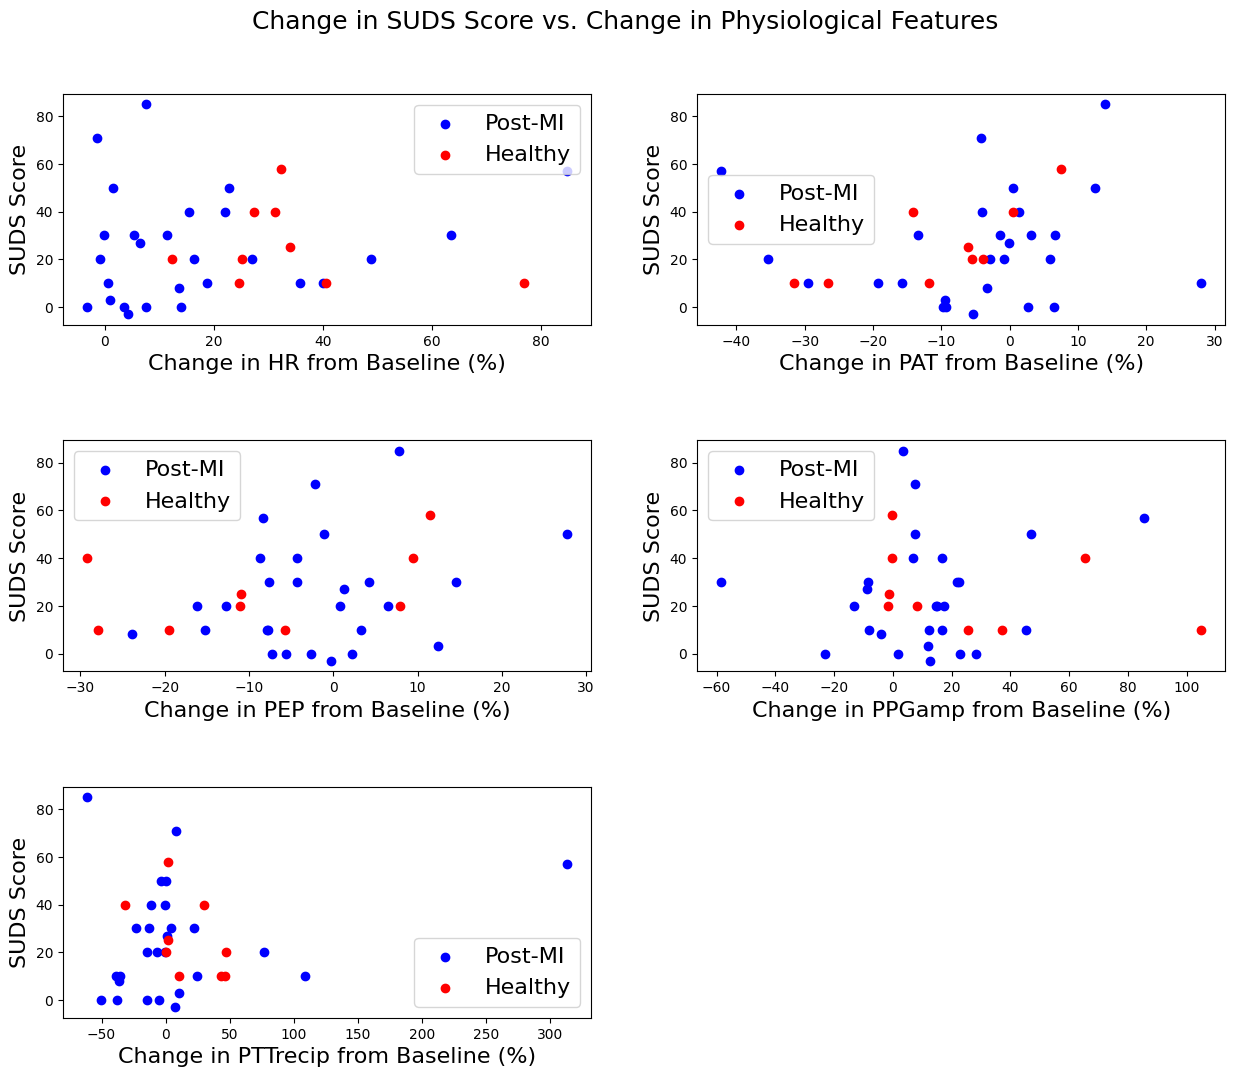

In [30]:
# Isolate features from speech preparation stimulus (stim 2), compute average, and plot against SUDS

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Change in SUDS Score vs. Change in Physiological Features", fontsize=18, y=0.95)

for i in range(NumFeat):

    speech_prep_feature_MI = []
    speech_prep_feature_Ht = []
    
    MI_idx = 0
    Ht_idx = 0
    
    for subj in subj_list:

        if str(subj)[0] == '3':
            baseline = dataframes_MI[MI_idx][0][i][:, 1]
            feature = dataframes_MI[MI_idx][2][i][:, 1]
            speech_prep_feature_MI.append(100*(np.mean(feature) - np.mean(baseline))/np.mean(baseline))
            MI_idx += 1
            
        if str(subj)[0] == '6':
            baseline = dataframes_Ht[Ht_idx][0][i][:, 1]
            feature = dataframes_Ht[Ht_idx][2][i][:, 1]
            speech_prep_feature_Ht.append(100*(np.mean(feature) - np.mean(baseline))/np.mean(baseline))
            Ht_idx += 1
    
    speech_prep_feature_MI = np.asarray(speech_prep_feature_MI)
    speech_prep_feature_Ht = np.asarray(speech_prep_feature_Ht)
    
    ax = plt.subplot(3, 2, i+1)
    ax.scatter(speech_prep_feature_MI, suds_post_speech_MI - suds_pre_speech_MI, color='b')
    ax.scatter(speech_prep_feature_Ht, suds_post_speech_Ht - suds_pre_speech_Ht, color='r')
    ax.set_xlabel('Change in ' + Feature[i] + " from Baseline (%)", fontsize = 16)
    ax.set_ylabel('SUDS Score', fontsize = 16)
    ax.legend(['Post-MI', 'Healthy'], fontsize = 16)

## II. Feature Extraction

In [36]:
# Compute baseline and speech prep features

from sklearn.preprocessing import StandardScaler

baseline_features = []
speechprep_features = []

baseline = 0
speechprep = 2

for subj_no in range(len(subj_list)):
    
    subj_baseline_features = []
    subj_speechprep_features = []
    
    # First, add the "health status" of the subject as a categorical feature
    subj_baseline_features.append(0)
    subj_speechprep_features.append(int(suds.patid.values[subj_no] / 6000))
    
    # Now, loop through the data in "Consolidated_Features" and compute additional simple statistical features
    for feat_no in range(NumFeat):
        
        if subj_no <= 26:
            baseline_signal = dataframes_MI[subj_no][baseline][feat_no][:, 1]
            speechprep_signal = dataframes_MI[subj_no][speechprep][feat_no][:, 1]
        else:
            baseline_signal = dataframes_Ht[subj_no-27][baseline][feat_no][:, 1]
            speechprep_signal = dataframes_Ht[subj_no-27][speechprep][feat_no][:, 1]
        
        # 1) Mean
        subj_baseline_features.append(np.mean(baseline_signal))
        subj_speechprep_features.append(np.mean(speechprep_signal))
        
        #2) Standard Deviation
        subj_baseline_features.append(np.std(baseline_signal))
        subj_speechprep_features.append(np.std(speechprep_signal))
        
        #3) Minimum
        subj_baseline_features.append(np.min(baseline_signal))
        subj_speechprep_features.append(np.min(speechprep_signal))
        
        #4) Maximum
        subj_baseline_features.append(np.max(baseline_signal))
        subj_speechprep_features.append(np.max(speechprep_signal))
        
        #5) Median
        subj_baseline_features.append(np.median(baseline_signal))
        subj_speechprep_features.append(np.median(speechprep_signal))
    
    # Finally, get the HRV features
    
    HRV_feat = pd.read_csv("HRV/HRV_feat_all/sub" + str(subj_list[subj_no]) + "_HRV_feat.csv")
    
    subj_baseline_features.extend(HRV_feat.iloc[baseline, 1:15].values)
    subj_speechprep_features.extend(HRV_feat.iloc[speechprep, 1:15].values)
    
    baseline_features.append(subj_baseline_features)
    speechprep_features.append(subj_speechprep_features)
    
scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(np.asarray(speechprep_features) - np.asarray(baseline_features)))
df[0][df[0].values > 0] = int(1)
df[0][df[0].values < 0] = int(0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,-0.323423,-0.079617,-0.511804,0.179631,-0.255809,0.228567,-0.345384,0.122558,0.460757,...,0.522447,-0.157346,0.635290,-0.143419,-0.018824,0.086828,-0.530355,-1.269654,1.269654,-0.122065
1,0.0,-1.030309,0.086845,-0.487766,-0.293686,-1.065513,0.405188,-1.240016,1.075301,-4.148660,...,0.185965,0.356550,-0.361973,0.298724,-0.018212,-0.069862,0.196498,0.504413,-0.504413,0.286995
2,0.0,0.499766,1.108652,1.045611,0.815706,0.303086,1.388059,1.221618,-0.118056,0.868678,...,0.083366,-0.305828,0.114460,0.000862,-0.071242,-0.070568,0.419705,0.092809,-0.092809,-0.083795
3,0.0,1.534688,2.068848,0.388942,0.883261,1.479928,-0.746117,-0.122584,-0.064994,-0.229912,...,0.676632,1.589268,-0.507140,0.918380,0.035200,0.049934,-0.083941,-0.308566,0.308566,1.095839
4,0.0,-0.520779,0.186297,-0.230054,-0.463600,-0.606595,1.202169,0.675383,3.409764,-1.031947,...,0.905510,0.221929,1.016181,0.193234,-0.134496,-0.956506,0.099203,-0.006556,0.006556,-0.435915


## III. Model Training/Testing

In [149]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.to_numpy()
y = np.concatenate((suds_post_speech_MI - suds_pre_speech_MI, suds_post_speech_Ht - suds_pre_speech_Ht))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Model 1: Linear Regression

In [150]:
model1 = linear_model.LinearRegression()

# fit training samples
model1.fit(X_train, y_train);

y_train_pred = model1.predict(X_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

y_test_pred = model1.predict(X_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 0.10
Train set: coefficient of determination: 1.00
Test set: mean squared error: 26482.42
Test set: coefficient of determination: -68.61


In [151]:
# Split once more for a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=4)

# Create lists to keep track of accuracy (MSE)
train_acc = []
val_acc = []
test_acc = []

### Model 2: Ridge Regression

In [152]:
# Model 2: ridge regression
regr2 = [] # list to store different models for hyperparam tuning
val_acc_temp = [] # list to store the MSE on the validation set for each model
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]): # loop through different values for alpha
    regr = linear_model.Ridge(alpha=alpha)
    regr.fit(X_train, y_train)
    y_val_pred = regr.predict(X_val)
    val_acc_temp.append(mean_squared_error(y_val, y_val_pred))
    regr2.append(regr)
regr2 = regr2[np.argmin(val_acc_temp)] # chose the model that performed best on the validation set
y_train_pred = regr2.predict(X_train)
y_test_pred = regr2.predict(X_test)
train_acc.append(mean_squared_error(y_train, y_train_pred))
val_acc.append(np.min(val_acc_temp)) # we already computed the validation accuracy
test_acc.append(mean_squared_error(y_test, y_test_pred))

### Model 3: LASSO

In [153]:
# Model 3: LASSO
regr3 = []
val_acc_temp = [] # list to store the MSE on the validation set for each model
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]): # loop through different values for alpha
    regr = linear_model.Lasso(alpha=alpha)
    regr.fit(X_train, y_train)
    y_val_pred = regr.predict(X_val)
    val_acc_temp.append(mean_squared_error(y_val, y_val_pred))
    regr3.append(regr)
regr3 = regr3[np.argmin(val_acc_temp)] # chose the model that performed best on the validation set
y_train_pred = regr3.predict(X_train)
y_test_pred = regr3.predict(X_test)
train_acc.append(mean_squared_error(y_train, y_train_pred))
val_acc.append(np.min(val_acc_temp)) # we already computed the validation accuracy
test_acc.append(mean_squared_error(y_test, y_test_pred))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.676e+00, tolerance: 9.885e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.985e+01, tolerance: 9.885e-01
  model = cd_fast.enet_coordinate_descent(


### Model 4: Elastic-Net w/L1 ratio = 0.95

In [154]:
regr4 = []
val_acc_temp = [] # list to store the MSE on the validation set for each model
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]): # loop through different values for alpha
    regr = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.95)
    regr.fit(X_train, y_train)
    y_val_pred = regr.predict(X_val)
    val_acc_temp.append(mean_squared_error(y_val, y_val_pred))
    regr4.append(regr)
regr4 = regr4[np.argmin(val_acc_temp)] # chose the model that performed best on the validation set
y_train_pred = regr4.predict(X_train)
y_test_pred = regr4.predict(X_test)
train_acc.append(mean_squared_error(y_train, y_train_pred))
val_acc.append(np.min(val_acc_temp)) # we already computed the validation accuracy
test_acc.append(mean_squared_error(y_test, y_test_pred))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e+01, tolerance: 9.885e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.683e+01, tolerance: 9.885e-01
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Testing Results')

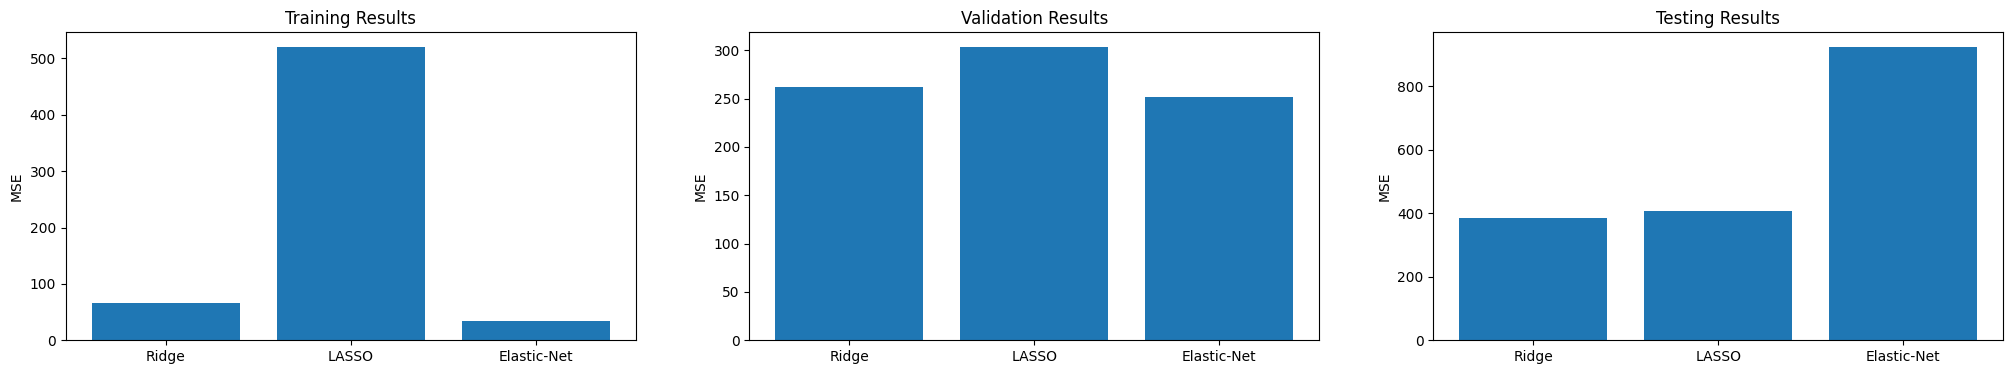

In [156]:
# Visualize the results
model_names = np.array(['Ridge', 'LASSO', 'Elastic-Net'])
fig, axs = plt.subplots(1, 3, figsize=(25, 4))
axs[0].bar(model_names, train_acc)
# axs[0].set_ylim([0.52, 0.53])
axs[0].set_ylabel('MSE')
axs[0].set_title('Training Results')

axs[1].bar(model_names, val_acc)
# axs[1].set_ylim([0.52, 0.525])
axs[1].set_ylabel('MSE')
axs[1].set_title('Validation Results')

axs[2].bar(model_names, test_acc)
# axs[2].set_ylim([0.525, 0.535])
axs[2].set_ylabel('MSE')
axs[2].set_title('Testing Results')